# MortalidadCR

**Este documento fue creado en jupyter Notebook con el fin de interpretar los datos más relevantes sobre muertes en carretera en el año 2024 en Costa Rica.

**Los datos son extraídos de la API de [COSEVI](https://datosabiertos.csv.go.cr/developers/)**

###### Proyecto realizado en su totalidad por Kevin Madriz Brenes.

In [7]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import json

In [8]:
### Extracción de Data desde API
###### Cambie su api_key desde el sitio oficial de COSEVI
api_key = "atWKJv0WdF3pnX5jhdMmaKo5zZ6wfA21HkQvclKo"
url = f"http://cosevi.cloudapi.junar.com/api/v2/datastreams/REGIS-DE-FALLE-EN-SITIO/data.json/?auth_key={api_key}"

In [9]:
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    fArray = data['result']['fArray']
    print("Datos cargados correctamente")
else:
    print(f"Error: {response.status_code}")

Datos cargados correctamente


In [13]:
#La API devuelve un JSON cuyo contenido relevante está en la clave result.fArray. 
#Esta es una lista de diccionarios, y cada diccionario representa una "celda" de la tabla. 
#La lista se organiza de la siguiente manera:

#Encabezados: Son los diccionarios donde la clave "fHeader" es True. 
#Estos contienen los nombres de las columnas, generalmente en la clave "fStr".

#Registros: Son los diccionarios donde "fHeader" no existe o es False. 
#Estos contienen los datos correspondientes a cada celda, también en la clave "fStr".

In [15]:
# Accedemos a la lista completa
fArray = data['result']['fArray']

# Extraemos los encabezados (los diccionarios que tienen fHeader True)
encabezados = [item['fStr'] for item in fArray if item.get('fHeader', False)]

# Extraemos los valores (los diccionarios sin fHeader True)
valores = [item['fStr'] for item in fArray if not item.get('fHeader', False)]

# Cantidad de columnas (número de encabezados)
n_columnas = len(encabezados)

# Agrupamos los valores en registros (filas) según el número de columnas
registros = [valores[i:i + n_columnas] for i in range(0, len(valores), n_columnas)]


In [17]:
df = pd.DataFrame(registros, columns=encabezados)

In [19]:
# Generador página HTML
html_tabla = df.to_html()
with open("tabla_fallecidos.html", "w", encoding="utf-8-sig") as f:
    f.write(html_tabla)

In [187]:
# Generador de archivo .csv
df.to_csv('datos_fallecidos.csv', index=False, encoding='utf-8-sig')

### Exploración inicial de la tabla

In [24]:
df.head()

,Año,Tipo de accidente,Provincia,Cantón,Ruta,Rol persona,Sexo,Edad,Franja,Día,Mes,Edad quinquenal
0,2024,Colisión entre vehículos,Guanacaste,Santa Cruz,152,Motociclista,Hombre,27,00-06,2.Lunes,A. Enero,25 A 29
1,2024,Colisión entre vehículos,Puntarenas,Parrita,34,Pasajero carro,Hombre,23,12-18,2.Lunes,A. Enero,20 A 24
2,2024,Colisión entre vehículos,Puntarenas,Osa,2,Pasajero carro,Hombre,48,06-12,5.Jueves,A. Enero,45 A 49
3,2024,Colisión entre vehículos,Puntarenas,Osa,2,Pasajero carro,Hombre,46,06-12,5.Jueves,A. Enero,45 A 49
4,2024,Colisión entre vehículos,Guanacaste,Liberia,21,Motociclista,Hombre,34,12-18,7.Sábado,A. Enero,30 A 34


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Año                505 non-null    object
 1   Tipo de accidente  505 non-null    object
 2   Provincia          505 non-null    object
 3   Cantón             505 non-null    object
 4   Ruta               505 non-null    object
 5   Rol persona        505 non-null    object
 6   Sexo               505 non-null    object
 7   Edad               505 non-null    object
 8   Franja             505 non-null    object
 9   Día                505 non-null    object
 10  Mes                505 non-null    object
 11  Edad quinquenal    505 non-null    object
dtypes: object(12)
memory usage: 47.5+ KB


In [28]:
df.describe()

,Año,Tipo de accidente,Provincia,Cantón,Ruta,Rol persona,Sexo,Edad,Franja,Día,Mes,Edad quinquenal
count,505,505,505,505,505,505,505,505,505,505,505,505
unique,1,11,8,77,87,9,4,68,4,7,12,16
top,2024,Colisión entre vehículos,Puntarenas,San Carlos,Cantonal o desconocida,Motociclista,Hombre,Desconocida,18-24,7.Sábado,L. Diciembre,25 A 29
freq,505,224,128,28,111,241,421,35,159,115,65,87


In [30]:
df.shape

(505, 12)

### Limpieza de Datos

In [33]:
df = df.drop(columns=['Año'])

In [35]:
df.isnull().sum()

Tipo de accidente    0
Provincia            0
Cantón               0
Ruta                 0
Rol persona          0
Sexo                 0
Edad                 0
Franja               0
Día                  0
Mes                  0
Edad quinquenal      0
dtype: int64

In [37]:
df = df.map(lambda x: x.lower().strip() if isinstance(x, str) else x)

In [39]:
df.columns = df.columns.str.lower().str.strip()

In [41]:
df.head()

,tipo de accidente,provincia,cantón,ruta,rol persona,sexo,edad,franja,día,mes,edad quinquenal
0,colisión entre vehículos,guanacaste,santa cruz,152,motociclista,hombre,27,00-06,2.lunes,a. enero,25 a 29
1,colisión entre vehículos,puntarenas,parrita,34,pasajero carro,hombre,23,12-18,2.lunes,a. enero,20 a 24
2,colisión entre vehículos,puntarenas,osa,2,pasajero carro,hombre,48,06-12,5.jueves,a. enero,45 a 49
3,colisión entre vehículos,puntarenas,osa,2,pasajero carro,hombre,46,06-12,5.jueves,a. enero,45 a 49
4,colisión entre vehículos,guanacaste,liberia,21,motociclista,hombre,34,12-18,7.sábado,a. enero,30 a 34


### Resumen de Datos

In [44]:
for col in df.columns:
    unique_values = df[col].unique()  # Obtiene valores únicos
    print(f"\n**Columna: {col}**")
    print(f"Categorías únicas: {len(unique_values)}")  # Cuenta los valores únicos
    print(f"Valores únicos: {unique_values}")  # Muestra los valores únicos
    print("-" * 50)



**Columna: tipo de accidente**
Categorías únicas: 9
Valores únicos: ['colisión entre vehículos' 'salió de la vía' 'atropello a persona'
 'colisión con bicicleta' 'colisión con objeto fijo' 'vuelco'
 'caída de algún ocupante' 'otros' 'colisión contra semoviente']
--------------------------------------------------

**Columna: provincia**
Categorías únicas: 7
Valores únicos: ['guanacaste' 'puntarenas' 'alajuela' 'san josé' 'heredia' 'cartago'
 'limón']
--------------------------------------------------

**Columna: cantón**
Categorías únicas: 71
Valores únicos: ['santa cruz' 'parrita' 'osa' 'liberia' 'nicoya' 'abangares' 'orotina'
 'san josé' 'naranjo' 'heredia' 'garabito' 'desamparados' 'alajuela'
 'buenos aires' 'puntarenas' 'atenas' 'san carlos' 'jiménez' 'carrillo'
 'san pablo' 'los chiles' 'cartago' 'la unión' 'acosta' 'quepos'
 'nandayure' 'guácimo' 'golfito' 'coto brus' 'tilarán' 'pococí' 'esparza'
 'san rafael' 'talamanca' 'upala' 'hojancha' 'bagaces' 'santa ana'
 'curridabat' 'es

### Totales

In [47]:
for col in df.columns:
    print(f"\n**Columna: {col}**")
    print(df[col].value_counts(dropna=False))  # Muestra valores únicos y sus conteos
    print("-" * 50)  # Separador para mejor visualización



**Columna: tipo de accidente**
tipo de accidente
colisión entre vehículos      224
salió de la vía                95
atropello a persona            80
colisión con bicicleta         38
colisión con objeto fijo       38
caída de algún ocupante        16
vuelco                         10
colisión contra semoviente      3
otros                           1
Name: count, dtype: int64
--------------------------------------------------

**Columna: provincia**
provincia
puntarenas    128
alajuela      116
san josé       78
guanacaste     66
limón          64
heredia        30
cartago        23
Name: count, dtype: int64
--------------------------------------------------

**Columna: cantón**
cantón
san carlos    28
pococí        26
san josé      26
alajuela      24
osa           23
              ..
palmares       1
san rafael     1
san pablo      1
jiménez        1
san mateo      1
Name: count, Length: 71, dtype: int64
--------------------------------------------------

**Columna: ruta**
ruta
ca

### Mortalidad en menores de edad

In [50]:
df['edad'] = pd.to_numeric(df['edad'], errors='coerce')

menores_de_edad = df[df['edad'] < 18]

if 'edad' in df.columns:
    menores_de_edad = menores_de_edad.sort_values(by='edad', ascending=True)
    
menores_de_edad


,tipo de accidente,provincia,cantón,ruta,rol persona,sexo,edad,franja,día,mes,edad quinquenal
76,salió de la vía,alajuela,los chiles,35,pasajero carro,mujer,6.0,18-24,4.miércoles,b. febrero,05 a 9
491,atropello a persona,cartago,turrialba,414,peatón,hombre,6.0,06-12,2.lunes,l. diciembre,05 a 9
19,colisión entre vehículos,puntarenas,garabito,34,pasajero carro,mujer,11.0,00-06,5.jueves,a. enero,10 a 14
174,salió de la vía,guanacaste,bagaces,cantonal o desconocida,pasajero moto,hombre,12.0,12-18,2.lunes,e. mayo,10 a 14
258,colisión entre vehículos,limón,talamanca,36,motociclista,mujer,14.0,12-18,6.viernes,g. julio,10 a 14
278,vuelco,puntarenas,puntarenas,1,pasajero carro,hombre,14.0,00-06,1.domingo,h. agosto,10 a 14
201,colisión entre vehículos,limón,siquirres,32,pasajero carro,mujer,15.0,00-06,1.domingo,f. junio,15 a 19
410,colisión con bicicleta,cartago,turrialba,10,ciclista,hombre,15.0,18-24,5.jueves,k. noviembre,15 a 19
18,colisión entre vehículos,puntarenas,garabito,34,pasajero carro,mujer,16.0,00-06,5.jueves,a. enero,15 a 19
152,colisión con bicicleta,alajuela,alajuela,126,ciclista,hombre,16.0,12-18,1.domingo,d. abril,15 a 19


### Cantones con más accidentes de tránsito

In [53]:
cantones_mas_peligroso = df.groupby('cantón').size()

cantones_mas_peligroso = cantones_mas_peligroso.sort_values(ascending=False)

cantones_mas_peligroso.head(10)

cantón
san carlos      28
san josé        26
pococí          26
alajuela        24
osa             23
puntarenas      22
garabito        16
nicoya          15
heredia         14
buenos aires    13
dtype: int64

### Provincias con más accidentes de tránsito

In [56]:
top_3_provincias = df.groupby('provincia').size()

top_3_provincias = top_3_provincias.sort_values(ascending=False)

top_3_provincias.head(3)

provincia
puntarenas    128
alajuela      116
san josé       78
dtype: int64

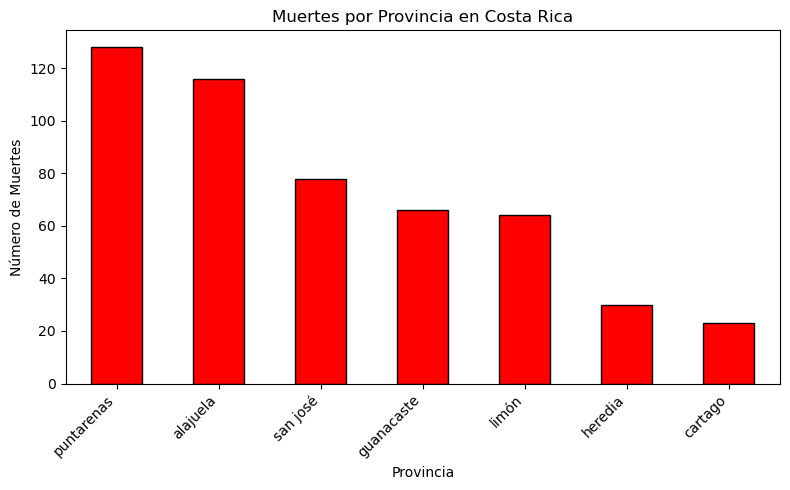

In [58]:
# Contar la cantidad de muertes por provincia
muertes_por_provincia = df['provincia'].value_counts()

# Gráfico de barras
plt.figure(figsize=(8,5))
muertes_por_provincia.plot(kind='bar', color='red', edgecolor='black')
plt.title('Muertes por Provincia en Costa Rica')
plt.xlabel('Provincia')
plt.ylabel('Número de Muertes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


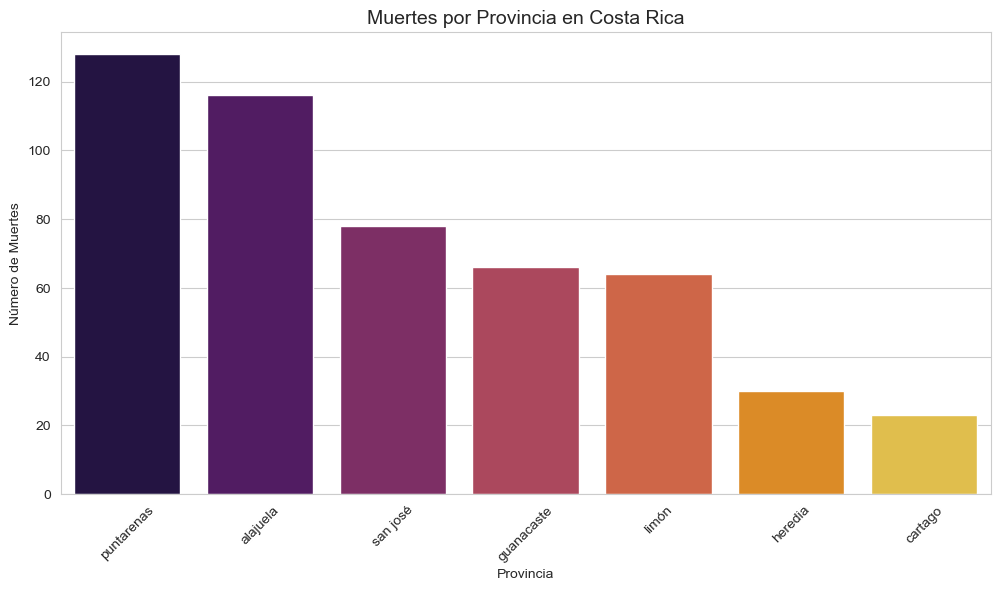

In [59]:
# Configurar estilo
sns.set_style("whitegrid")

# Contar muertes por provincia
muertes_por_provincia = df['provincia'].value_counts().reset_index()
muertes_por_provincia.columns = ['provincia', 'Total']

# Crear gráfico de barras
plt.figure(figsize=(12,6))
sns.barplot(x='provincia', y='Total', data=muertes_por_provincia, hue='provincia', palette='inferno', legend=False)
plt.title('Muertes por Provincia en Costa Rica', fontsize=14)
plt.xlabel('Provincia')
plt.ylabel('Número de Muertes')
plt.xticks(rotation=45)
plt.show()



### Muertes por Mes

In [63]:
muertes_por_mes = df['mes'].value_counts().sort_index()
muertes_por_mes

mes
a. enero        41
b. febrero      37
c. marzo        39
d. abril        39
e. mayo         43
f. junio        32
g. julio        33
h. agosto       34
i. setiembre    55
j. octubre      41
k. noviembre    46
l. diciembre    65
Name: count, dtype: int64

### Muertes por Día

In [66]:
muertes_por_dia = df['día'].value_counts().sort_index()
muertes_por_dia

día
1.domingo       97
2.lunes         51
3.martes        59
4.miércoles     53
5.jueves        60
6.viernes       70
7.sábado       115
Name: count, dtype: int64

### Muertes por grupos de Edad

Con Seaborn

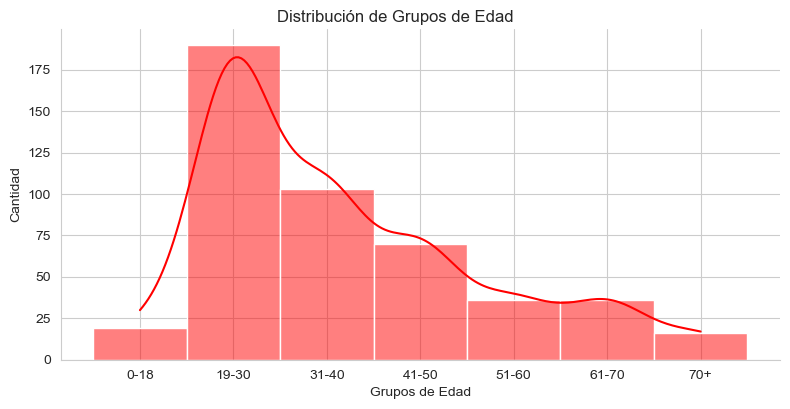

In [70]:
# Definir los bins y labels para los grupos de edad
bins = [0, 18, 30, 40, 50, 60, 70, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '70+']

# Asignar los grupos de edad
df['Grupo de Edad'] = pd.cut(df['edad'], bins=bins, labels=labels)

# Convertir la columna a tipo Categorical con el orden deseado
df['Grupo de Edad'] = pd.Categorical(df['Grupo de Edad'], categories=labels, ordered=True)

# Crear la visualización de la distribución de los grupos de edad
g = sns.displot(data=df,
                x="Grupo de Edad",
                kind="hist",
                kde=True,
                color="red",
                height=4,
                aspect=2)

# Mejorar el título y las etiquetas
g.fig.suptitle('Distribución de Grupos de Edad',
               va='baseline',
               ha='center')
g.set_axis_labels('Grupos de Edad', 'Cantidad')

# Mostrar la gráfica
plt.show()


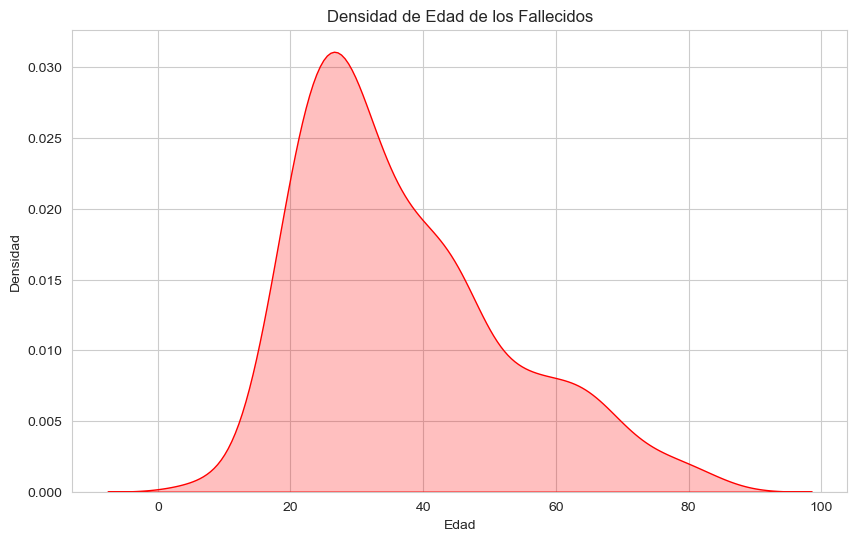

In [72]:
plt.figure(figsize=(10,6))
sns.kdeplot(df['edad'], fill=True, color='red')
plt.title('Densidad de Edad de los Fallecidos')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.show()

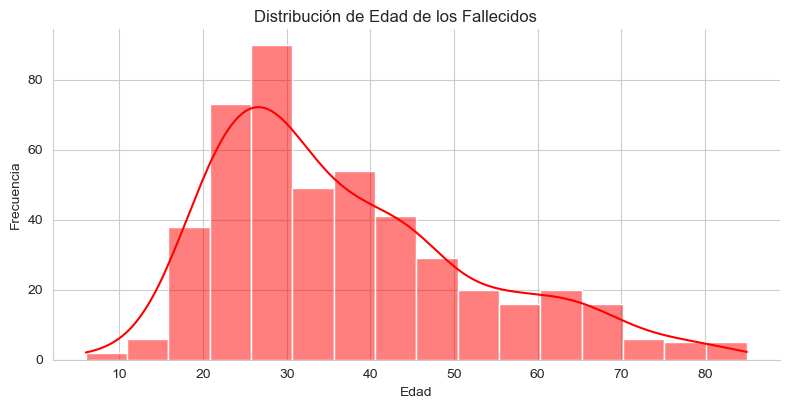

In [73]:
# Crear el gráfico
g = sns.displot(data=df,
                x="edad",  # Cambiar a la columna que desees, por ejemplo "edad"
                kind="hist",  # Histograma
                kde=True,  # Agregar la curva KDE
                color="red",  # Color del gráfico
                height=4,  # Altura del gráfico
                aspect=2)  # Relación de aspecto

# Título del gráfico
g.fig.suptitle('Distribución de Edad de los Fallecidos', 
               va='baseline', 
               ha='center')

# Etiquetas de los ejes
g.set_axis_labels('Edad', 'Frecuencia')

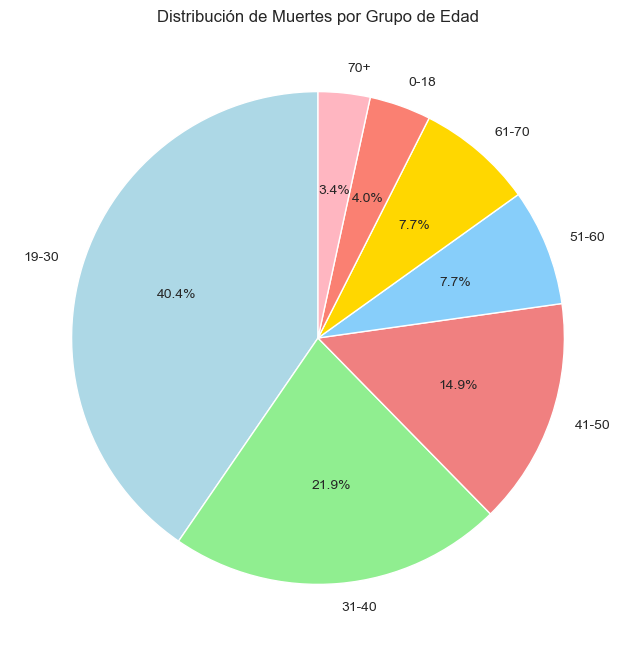

In [75]:
# Contar las muertes por grupo de edad
muertes_por_edad = df['Grupo de Edad'].value_counts()

# Gráfico de pastel
plt.figure(figsize=(8,8))
muertes_por_edad.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'gold', 'salmon', 'lightpink'])
plt.title('Distribución de Muertes por Grupo de Edad')
plt.ylabel('')  # Eliminar la etiqueta por defecto
plt.show()

### Estadísticas Generales

In [78]:
edad_promedio = np.mean(df['edad'])
edad_mediana = np.median(df['edad'])
desviacion_estandar = np.std(df['edad'])

print(f"Edad Promedio: {edad_promedio}")
print(f"Edad Mediana: {edad_mediana}")
print(f"Desviación Estándar: {desviacion_estandar}")

Edad Promedio: 36.95106382978724
Edad Mediana: nan
Desviación Estándar: 15.504692115345943


### Accidentes por tipo

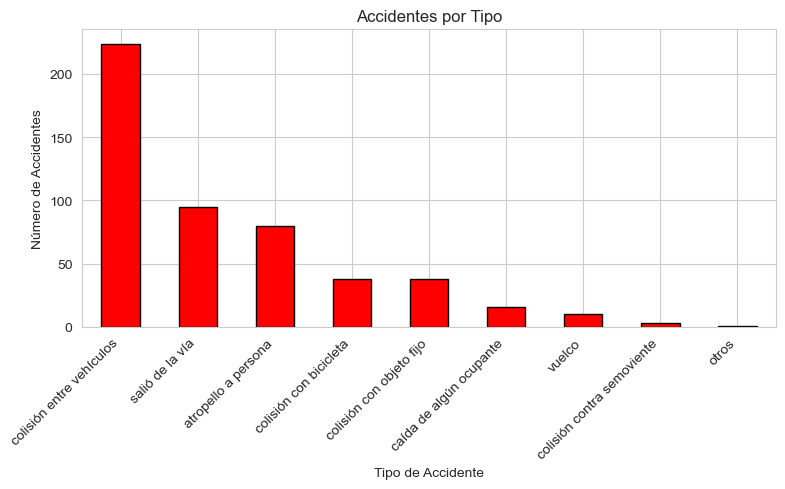

In [82]:
# Contar accidentes por tipo
accidentes_por_tipo = df['tipo de accidente'].value_counts()

# Gráfico de barras
plt.figure(figsize=(8,5))
accidentes_por_tipo.plot(kind='bar', color='red', edgecolor='black')
plt.title('Accidentes por Tipo')
plt.xlabel('Tipo de Accidente')
plt.ylabel('Número de Accidentes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Relación entre Edad y el tipo de Accidente

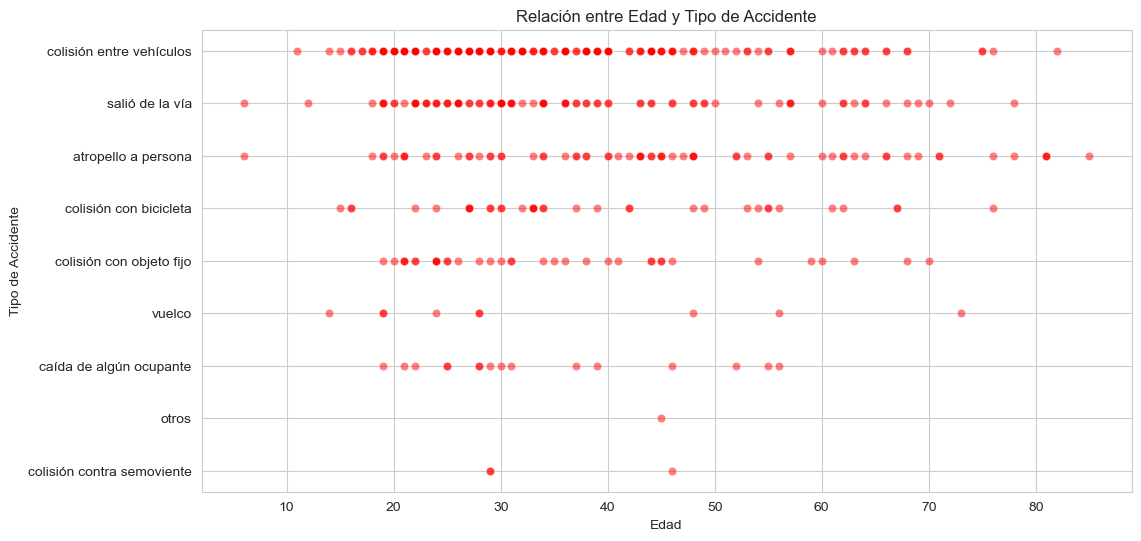

In [85]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='edad', y='tipo de accidente', data=df, alpha=0.5, color='red')
plt.title('Relación entre Edad y Tipo de Accidente')
plt.xlabel('Edad')
plt.ylabel('Tipo de Accidente')
plt.show()


### Relación entre Tipo de accidente y Sexo de las Personas

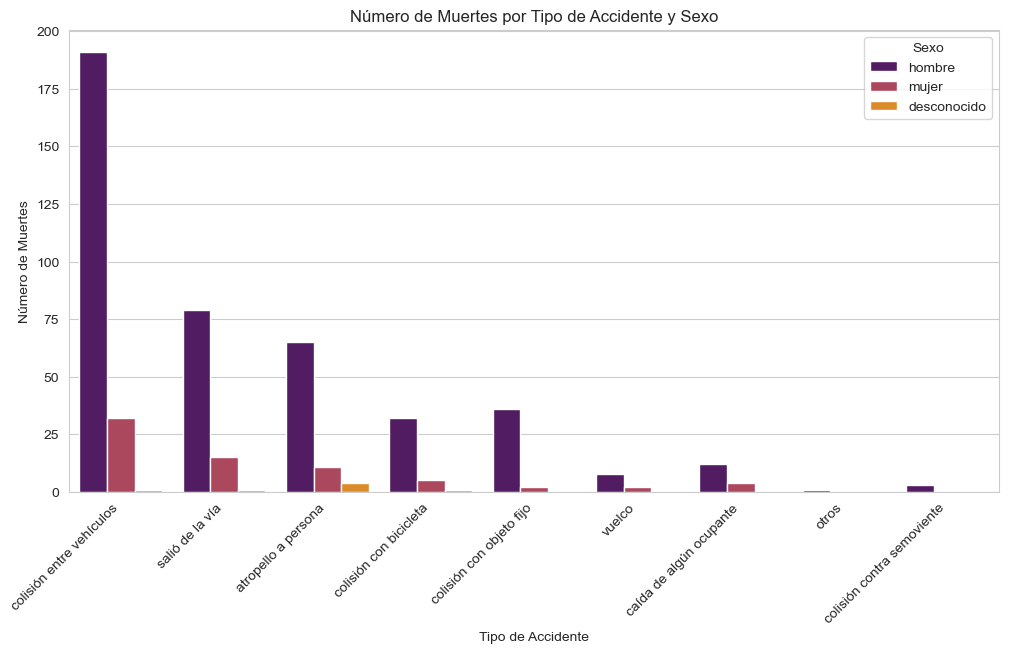

In [88]:
plt.figure(figsize=(12,6))
sns.countplot(x='tipo de accidente', hue='sexo', data=df, palette='inferno')
plt.title('Número de Muertes por Tipo de Accidente y Sexo')
plt.xlabel('Tipo de Accidente')
plt.ylabel('Número de Muertes')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sexo')
plt.show()

### Frecuencia entre el Tipo de Accidente y el Mes

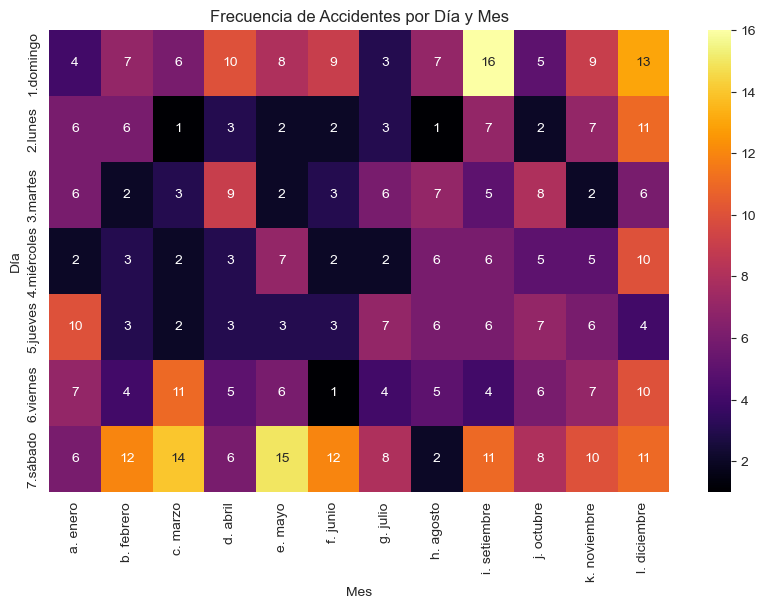

In [91]:
plt.figure(figsize=(10,6))
df_pivot = df.pivot_table(index='día', columns='mes', aggfunc='size', fill_value=0)

sns.heatmap(df_pivot, cmap='inferno', annot=True, fmt='d')
plt.title('Frecuencia de Accidentes por Día y Mes')
plt.xlabel('Mes')
plt.ylabel('Día')
plt.show()

## Machine Learning
Exploremos otros datos interesantes de la base de datos que nos brinda la API  de COSEVI

In [94]:
df2 = pd.read_csv('datos_fallecidos.csv')

In [96]:
df2 = df2.map(lambda x: x.lower().strip() if isinstance(x, str) else x)

In [98]:
df2.columns = df2.columns.str.lower().str.strip()

In [100]:
df2.head()

,año,tipo de accidente,provincia,cantón,ruta,rol persona,sexo,edad,franja,día,mes,edad quinquenal
0,2024,colisión entre vehículos,guanacaste,santa cruz,152,motociclista,hombre,27,00-06,2.lunes,a. enero,25 a 29
1,2024,colisión entre vehículos,puntarenas,parrita,34,pasajero carro,hombre,23,12-18,2.lunes,a. enero,20 a 24
2,2024,colisión entre vehículos,puntarenas,osa,2,pasajero carro,hombre,48,06-12,5.jueves,a. enero,45 a 49
3,2024,colisión entre vehículos,puntarenas,osa,2,pasajero carro,hombre,46,06-12,5.jueves,a. enero,45 a 49
4,2024,colisión entre vehículos,guanacaste,liberia,21,motociclista,hombre,34,12-18,7.sábado,a. enero,30 a 34


In [142]:
X = df2.drop(columns=['año', 'cantón', 'ruta', 'tipo de accidente'], axis=1)

In [144]:
X.head()

,provincia,rol persona,sexo,edad,franja,día,mes,edad quinquenal
0,guanacaste,motociclista,hombre,27,00-06,2.lunes,a. enero,25 a 29
1,puntarenas,pasajero carro,hombre,23,12-18,2.lunes,a. enero,20 a 24
2,puntarenas,pasajero carro,hombre,48,06-12,5.jueves,a. enero,45 a 49
3,puntarenas,pasajero carro,hombre,46,06-12,5.jueves,a. enero,45 a 49
4,guanacaste,motociclista,hombre,34,12-18,7.sábado,a. enero,30 a 34


In [148]:
y = df['tipo de accidente']

In [150]:
y.head()

0    colisión entre vehículos
1    colisión entre vehículos
2    colisión entre vehículos
3    colisión entre vehículos
4    colisión entre vehículos
Name: tipo de accidente, dtype: object

In [156]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Seleccionar las columnas categóricas
categorical_columns = ['provincia', 'rol persona', 'sexo', 'día', 'mes', 'edad quinquenal']

# Aplicar OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_columns])

# Obtener nombres de las nuevas columnas
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# Convertir en DataFrame
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_columns)

# Concatenar con las columnas numéricas originales
X_numeric = X.drop(columns=categorical_columns)  # Eliminar las columnas originales categóricas
X_final = pd.concat([X_numeric, X_encoded_df], axis=1)

# Verificar que todo es numérico
print(X_final.dtypes)

# Reemplazar X con los valores numéricos
X = X_final

edad                               object
franja                             object
provincia_alajuela                float64
provincia_cartago                 float64
provincia_guanacaste              float64
provincia_heredia                 float64
provincia_limón                   float64
provincia_puntarenas              float64
provincia_san josé                float64
rol persona_ciclista              float64
rol persona_conductor             float64
rol persona_motociclista          float64
rol persona_otro                  float64
rol persona_pasajero bicicleta    float64
rol persona_pasajero bus          float64
rol persona_pasajero carro        float64
rol persona_pasajero moto         float64
rol persona_peatón                float64
sexo_desconocido                  float64
sexo_hombre                       float64
sexo_mujer                        float64
día_1.domingo                     float64
día_2.lunes                       float64
día_3.martes                      

In [158]:
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median())

In [160]:
print(X.dtypes)

edad                              float64
franja                            float64
provincia_alajuela                float64
provincia_cartago                 float64
provincia_guanacaste              float64
provincia_heredia                 float64
provincia_limón                   float64
provincia_puntarenas              float64
provincia_san josé                float64
rol persona_ciclista              float64
rol persona_conductor             float64
rol persona_motociclista          float64
rol persona_otro                  float64
rol persona_pasajero bicicleta    float64
rol persona_pasajero bus          float64
rol persona_pasajero carro        float64
rol persona_pasajero moto         float64
rol persona_peatón                float64
sexo_desconocido                  float64
sexo_hombre                       float64
sexo_mujer                        float64
día_1.domingo                     float64
día_2.lunes                       float64
día_3.martes                      

In [162]:
arbol = DecisionTreeClassifier(max_depth=3, random_state=42)

In [164]:
arbol.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [166]:
pred_y = arbol.predict(X)
print('Precisión: ', accuracy_score(pred_y, y))

Precisión:  0.6455445544554456


In [168]:
confusion_matrix(y, pred_y)

array([[ 72,   0,   2,   0,   0,   6,   0,   0,   0],
       [  0,   0,   0,   0,   0,  16,   0,   0,   0],
       [  2,   0,  33,   0,   0,   3,   0,   0,   0],
       [  1,   0,   1,   0,   0,  36,   0,   0,   0],
       [  0,   0,   0,   0,   0,   3,   0,   0,   0],
       [  1,   0,   2,   0,   0, 221,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   1,   0,   0,  94,   0,   0,   0],
       [  0,   0,   0,   0,   0,  10,   0,   0,   0]], dtype=int64)

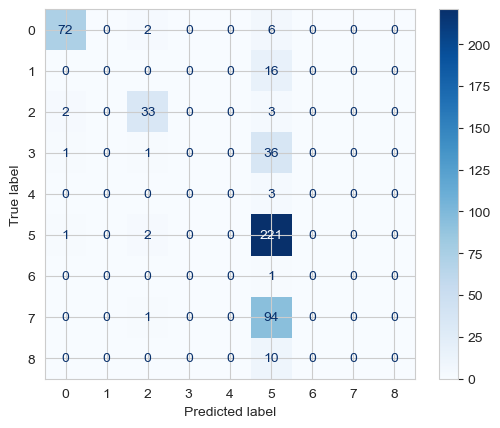

In [170]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Generar predicciones
y_pred = arbol.predict(X)

# Calcular matriz de confusión
cm = confusion_matrix(y, y_pred)

# Crear y mostrar la gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='.0f')

plt.show()

[Text(0.5416666666666666, 0.875, 'rol persona_peatón <= 0.5\ngini = 0.73\nsamples = 505\nvalue = [80, 16, 38, 38, 3, 224, 1, 95, 10]'),
 Text(0.3333333333333333, 0.625, 'rol persona_ciclista <= 0.5\ngini = 0.67\nsamples = 434\nvalue = [10.0, 16.0, 38.0, 38.0, 3.0, 223.0, 1.0, 95.0, 10.0]'),
 Text(0.4375, 0.75, 'True  '),
 Text(0.16666666666666666, 0.375, 'rol persona_motociclista <= 0.5\ngini = 0.61\nsamples = 389\nvalue = [6.0, 16.0, 3.0, 36.0, 3.0, 220.0, 1.0, 94.0, 10.0]'),
 Text(0.08333333333333333, 0.125, 'gini = 0.697\nsamples = 148\nvalue = [4, 7, 1, 17, 1, 64, 0, 46, 8]'),
 Text(0.25, 0.125, 'gini = 0.533\nsamples = 241\nvalue = [2, 9, 2, 19, 2, 156, 1, 48, 2]'),
 Text(0.5, 0.375, 'edad quinquenal_40 a 44 <= 0.5\ngini = 0.38\nsamples = 45\nvalue = [4, 0, 35, 2, 0, 3, 0, 1, 0]'),
 Text(0.4166666666666667, 0.125, 'gini = 0.277\nsamples = 39\nvalue = [2, 0, 33, 1, 0, 2, 0, 1, 0]'),
 Text(0.5833333333333334, 0.125, 'gini = 0.722\nsamples = 6\nvalue = [2, 0, 2, 1, 0, 1, 0, 0, 0]'),


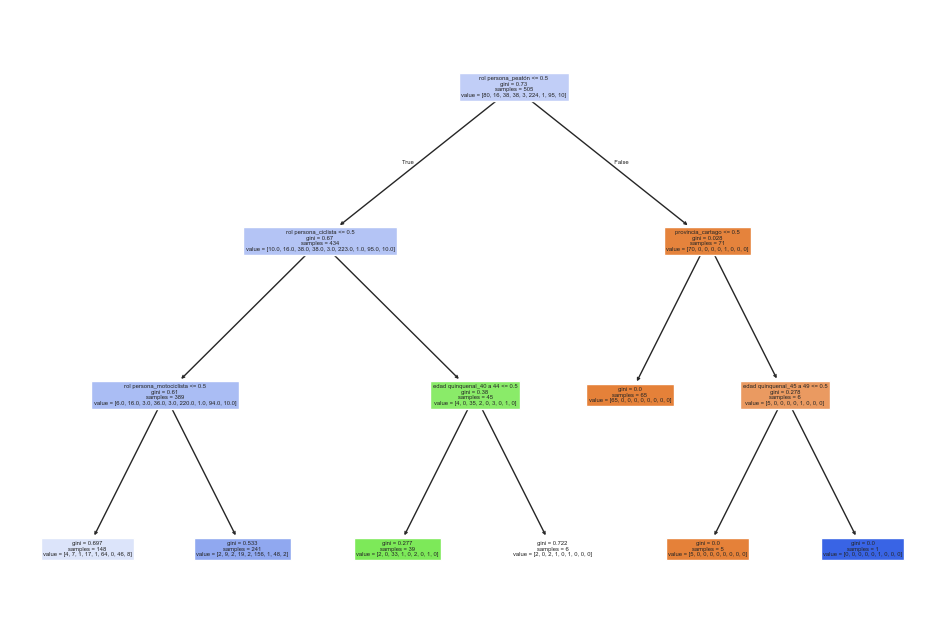

In [175]:
plt.figure(figsize=(12,8))
tree.plot_tree(arbol, filled = True, feature_names=X.columns)

In [179]:
from sklearn.preprocessing import LabelEncoder

# Crear y ajustar LabelEncoder
tipo_accidente_encoder = LabelEncoder()
df['tipo de accidente'] = tipo_accidente_encoder.fit_transform(df['tipo de accidente'])

In [181]:
tipo_accidente_mapping = dict(zip(tipo_accidente_encoder.classes_, tipo_accidente_encoder.transform(tipo_accidente_encoder.classes_)))

print("Mapeo de tipo de accidente:", tipo_accidente_mapping)


Mapeo de tipo de accidente: {'atropello a persona': 0, 'caída de algún ocupante': 1, 'colisión con bicicleta': 2, 'colisión con objeto fijo': 3, 'colisión contra semoviente': 4, 'colisión entre vehículos': 5, 'otros': 6, 'salió de la vía': 7, 'vuelco': 8}


In [183]:
accidente_cartago = [key for key, value in tipo_accidente_mapping.items() if value == 0][0]
print("El tipo de accidente más común en Cartago es:", accidente_cartago)

El tipo de accidente más común en Cartago es: atropello a persona


¿Cómo podemos interpretar esto?
Peatones pueden estar más asociados con atropellos.

Motociclistas pueden estar más asociados con colisiones o caídas de ocupantes.

Ciclistas podrían tener su propio patrón de accidentes.

Esto significa que el tipo de usuario en la vía es un factor determinante en el tipo de accidente que ocurre.

El accidente más común en la provincia de Cartago son los atropellos.